In [1]:
import datetime
import json
import os
import mthree
import numpy as np
from qiskit import IBMQ
from qiskit_experiments.framework import ExperimentEncoder
from qiskit_research.mzm_generation import (
    KitaevHamiltonianExperiment,
    KitaevHamiltonianExperimentParameters,
)
from qiskit_research.mzm_generation.utils import transpile_circuit
from qiskit_research.mzm_generation.utils import pick_qubit_layout, orbital_combinations

from qiskit.circuit.library import RZGate
from qiskit_research.utils.dynamical_decoupling import get_instruction_durations

from qiskit.visualization import timeline_drawer

In [2]:
# get backend

# uncomment to use hardware backend
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend_name = 'ibm_washington'

# Aer simulator backend
# provider = None
# backend_name = "aer_simulator"

In [10]:
# experiment parameters
n_modes = 12
tunneling_values = [-1.0]
superconducting_values = [1.0]
chemical_potential_values = list(np.linspace(0.0, 3.0, num=5))
occupied_orbitals_list = list(orbital_combinations(n_modes, threshold=2))
# dynamical_decoupling_sequences = None
dynamical_decoupling_sequences=['X2']
num_dd_passes=1
uhrig_spacing = False
concat_layers = 1
shots = 10000
readout_calibration_shots = 10000

# pick qubits
qubits, backend_name, error_score = pick_qubit_layout(n_modes, backend_name, provider)
print(f"Using qubits {qubits}.")

# date
date = datetime.datetime.now().isoformat()

# create experiment
params = KitaevHamiltonianExperimentParameters(
    timestamp=date,
    backend_name=backend_name,
    qubits=qubits,
    n_modes=n_modes,
    tunneling_values=tunneling_values,
    superconducting_values=superconducting_values,
    chemical_potential_values=chemical_potential_values,
    occupied_orbitals_list=occupied_orbitals_list,
    dynamical_decoupling_sequences=dynamical_decoupling_sequences,
    num_dd_passes=num_dd_passes,
    uhrig_spacing=uhrig_spacing,
    concat_layers=concat_layers,
    seed=11364,
)
experiment = KitaevHamiltonianExperiment(params, provider)

print(f"Total number of circuits: {len(experiment.circuits())}")

Using qubits [35, 47, 48, 49, 50, 51, 36, 32, 31, 30, 29, 28].
Total number of circuits: 750


In [14]:
from qiskit.transpiler import CouplingMap
print(CouplingMap(experiment.backend.configuration().coupling_map))

[[0, 1], [0, 14], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 5], [4, 15], [5, 4], [5, 6], [6, 5], [6, 7], [7, 6], [7, 8], [8, 7], [8, 16], [9, 10], [10, 9], [10, 11], [11, 10], [11, 12], [12, 11], [12, 13], [12, 17], [13, 12], [14, 0], [14, 18], [15, 4], [15, 22], [16, 8], [16, 26], [17, 12], [17, 30], [18, 14], [18, 19], [19, 18], [19, 20], [20, 19], [20, 21], [20, 33], [21, 20], [21, 22], [22, 15], [22, 21], [22, 23], [23, 22], [23, 24], [24, 23], [24, 25], [24, 34], [25, 24], [25, 26], [26, 16], [26, 25], [26, 27], [27, 26], [27, 28], [28, 27], [28, 29], [28, 35], [29, 28], [29, 30], [30, 17], [30, 29], [30, 31], [31, 30], [31, 32], [32, 31], [32, 36], [33, 20], [33, 39], [34, 24], [34, 43], [35, 28], [35, 47], [36, 32], [36, 51], [37, 38], [37, 52], [38, 37], [38, 39], [39, 33], [39, 38], [39, 40], [40, 39], [40, 41], [41, 40], [41, 42], [41, 53], [42, 41], [42, 43], [43, 34], [43, 42], [43, 44], [44, 43], [44, 45], [45, 44], [45, 46], [45, 54], [46, 45], [46, 47],

In [12]:
%%time

# schedule readout calibration
print("Scheduling readout calibration ...")
mit = mthree.M3Mitigation(experiment.backend)
mit.cals_from_system(qubits, shots=readout_calibration_shots, async_cal=True)

# schedule experiment jobs
print(f"Scheduling experiment ...")
# limit number of circuits per job to avoid timeouts
experiment.backend.configuration().max_experiments = 300
data = experiment.run(shots=shots)
if provider:
    # this only works if the Qiskit Experiments database service is available
    data.save()

# save readout calibration
filename = f"data/readout_calibration/{experiment.backend.name()}/{date}.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
print(f"Waiting for readout calibration data ...")
mit.cals_to_file(filename)
print(f"Readout calibration saved.")

# data.block_for_results()

# save data
# filename = f"data/{params.backend_name}/{params.filename}.json"
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# with open(filename, "w") as f:
#     json.dump(data, f, cls=ExperimentEncoder)

# print(params.filename)

Scheduling readout calibration ...
Scheduling experiment ...
113040
117392


CouplingError: 'coupling_map must be connected.'

In [ ]:
data.block_for_results()

# save data
filename = f"data/{params.backend_name}/{params.filename}.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, "w") as f:
    json.dump(data, f, cls=ExperimentEncoder)

print(params.filename)

113040


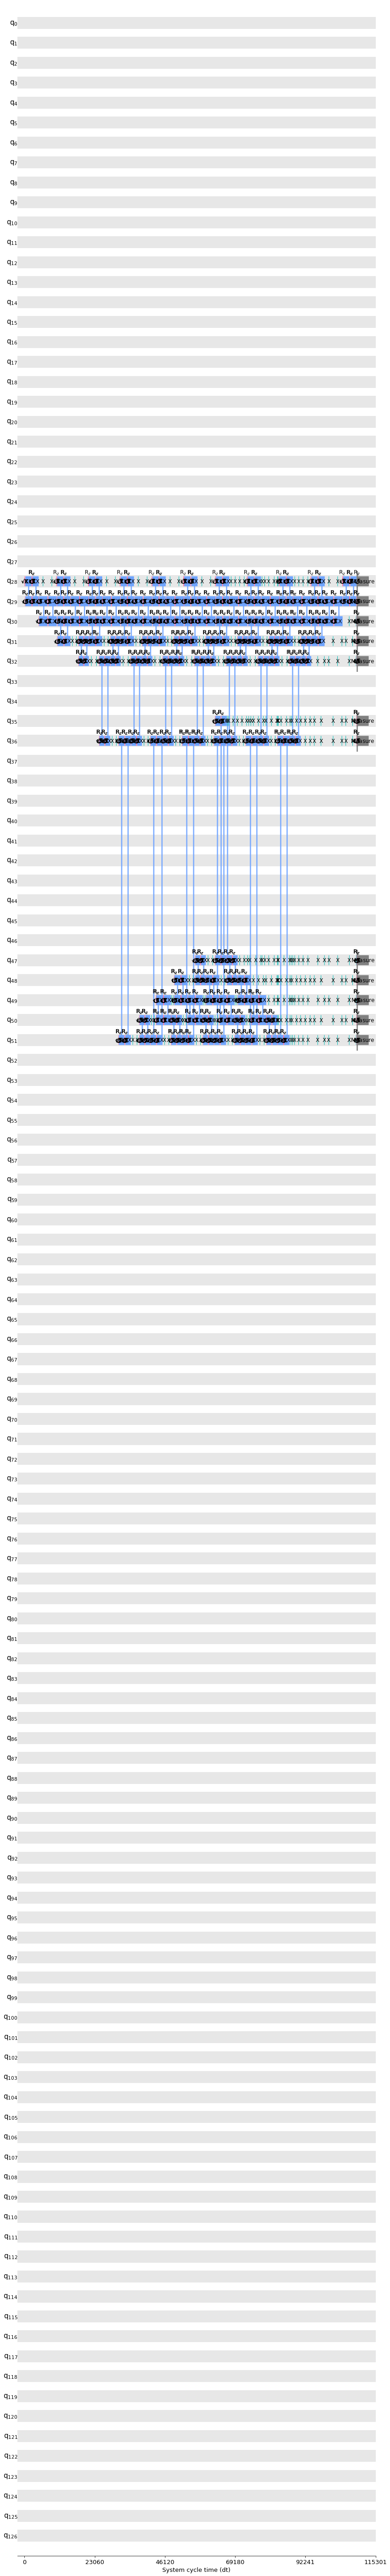

In [11]:
circ = transpile_circuit(
    experiment.circuits()[0],
    experiment.backend,
    initial_layout=list(experiment.physical_qubits),
    dynamical_decoupling_sequence=dynamical_decoupling_sequences[0],
    num_dd_passes=1,
    uhrig_spacing=False,
    concat_layers=1,
    pulse_scaling=experiment.params.pulse_scaling,
    pauli_twirling=bool(experiment.params.num_twirled_circuits),
    seed=experiment.rng,
)
timeline_drawer(circ)
# experiment.circuits()[0].draw('mpl')

113040


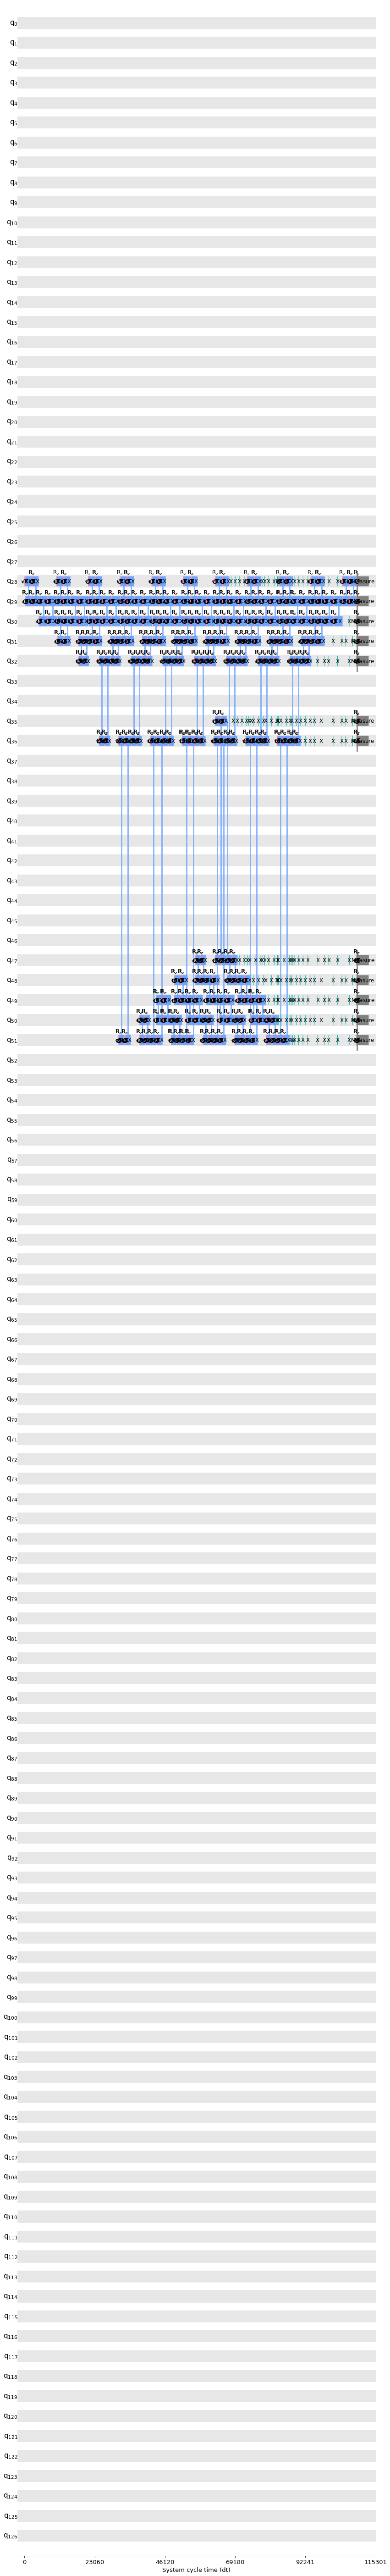

In [4]:
circ = transpile_circuit(
    experiment.circuits()[0],
    experiment.backend,
    initial_layout=list(experiment.physical_qubits),
    dynamical_decoupling_sequence=dynamical_decoupling_sequences[0],
    num_dd_passes=1,
    uhrig_spacing=False,
    concat_layers=1,
    pulse_scaling=experiment.params.pulse_scaling,
    pauli_twirling=bool(experiment.params.num_twirled_circuits),
    seed=experiment.rng,
)
timeline_drawer(circ)
# experiment.circuits()[0].draw('mpl')

92656


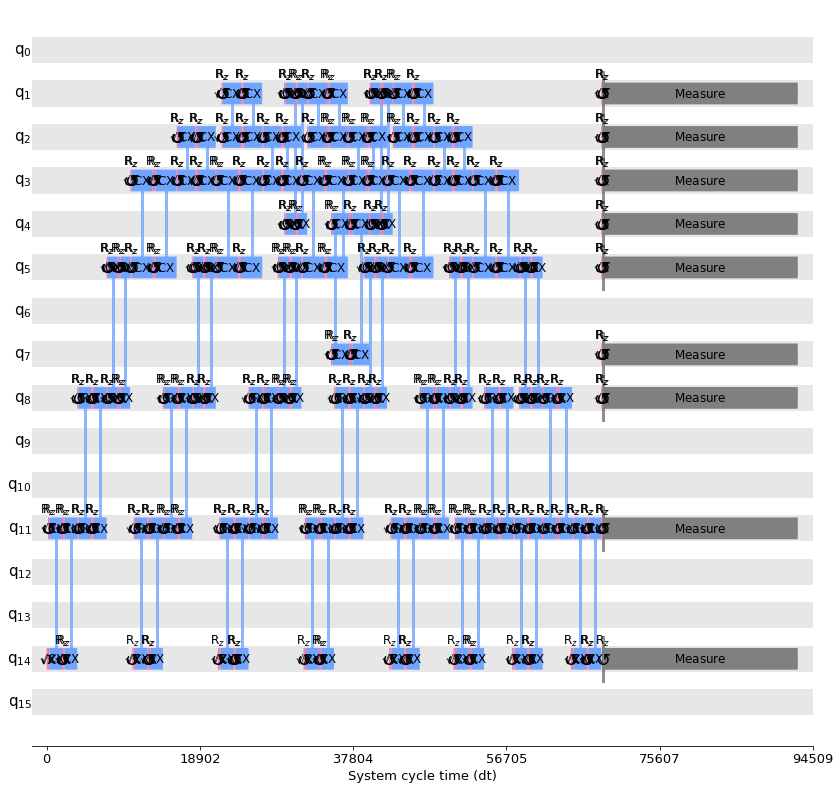

In [7]:
circ = transpile_circuit(
    experiment.circuits()[0],
    experiment.backend,
    initial_layout=list(experiment.physical_qubits),
    dynamical_decoupling_sequence=dynamical_decoupling_sequences[0],
    num_dd_passes=1,
    uhrig_spacing=False,
    concat_layers=1,
    pulse_scaling=experiment.params.pulse_scaling,
    pauli_twirling=bool(experiment.params.num_twirled_circuits),
    seed=experiment.rng,
)
timeline_drawer(circ)
# experiment.circuits()[0].draw('mpl')

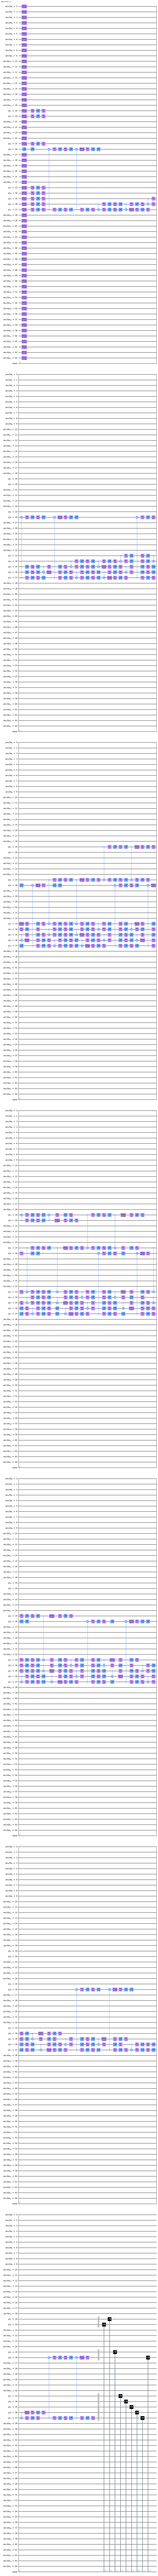

In [5]:
circ.draw('mpl')